<a href="https://colab.research.google.com/github/ammshreya/TwitterSenitimentAnalysis/blob/main/twitterSentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
# utilities
import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [86]:
# Importing the dataset
DATASET_COLUMNS=['text','target','date','flag','ids','user']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('Twitter_Data.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.sample(5)
# df = pd.read_csv('sample_data.csv')

,text,target,date,flag,ids,user
19189,yes just like modi lacs each account,0,Tue Jun 16 19:02:18 PDT 2011,NO_QUERY,1591028475,lizzy_anne06
8059,please understand promising lakhs each crore p...,1,Tue Jun 16 19:05:42 PDT 2011,NO_QUERY,1470057496,HomesteadMommy
23399,dude large heart right youre saying people wit...,1,Tue Jun 16 18:17:14 PDT 2013,NO_QUERY,1623164259,gerrymoth
5010,No more early morning flights... Sooo tired,1,Tue Jun 16 19:01:51 PDT 2010,NO_QUERY,1468966100,PrncssKT
15467,before election modi hows the khauf modi hater...,1,Tue Jun 16 18:39:42 PDT 2009,NO_QUERY,1562617695,paulinefraser


In [88]:
df.head()


,text,target,date,flag,ids,user
0,text,target,date,flag,ids,user
1,is upset that he can't update his Facebook by ...,-1,Tue Jun 16 18:02:22 PDT 2009,NO_QUERY,1467810672,scotthamilton
2,@Kenichan I dived many times for the ball. Man...,0,Tue Jun 16 18:02:22 PDT 2009,NO_QUERY,1467810917,mattycus
3,my whole body feels itchy and like its on fire,1,Tue Jun 16 18:02:23 PDT 2009,NO_QUERY,1467811184,ElleCTF
4,"@nationwideclass no, it's not behaving at all....",1,Tue Jun 16 18:02:23 PDT 2009,NO_QUERY,1467811193,Karoli


In [89]:
df.columns

Index(['text', 'target', 'date', 'flag', 'ids', 'user'], dtype='object')

In [90]:
print("The length of the dataset is : ",len(df))

The length of the dataset is :  23589


In [91]:
df.shape

(23589, 6)

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23589 entries, 0 to 23588
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    23589 non-null  object
 1   target  23589 non-null  object
 2   date    23589 non-null  object
 3   flag    23588 non-null  object
 4   ids     23588 non-null  object
 5   user    23588 non-null  object
dtypes: object(6)
memory usage: 1.1+ MB


In [93]:
df.dtypes

text      object
target    object
date      object
flag      object
ids       object
user      object
dtype: object

In [94]:
np.sum(df.isnull().any(axis=1))

1

In [95]:
print('Count of columns in the data is:  ', len(df.columns))
print('Count of rows in the data is:  ', len(df))

Count of columns in the data is:   6
Count of rows in the data is:   23589


In [96]:
df['target'].unique()

array(['target', '-1', '0', '1'], dtype=object)

In [97]:
df['target'].nunique()

4

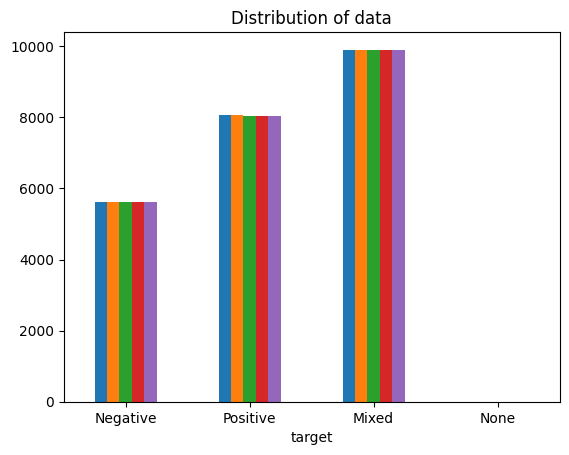

In [100]:
# Plotting the distribution for dataset.
ax = df.groupby('target').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive','Mixed','None'], rotation=0)
# Storing data in lists.
text, sentiment = list(df['text']), list(df['target'])

<Axes: xlabel='target', ylabel='count'>

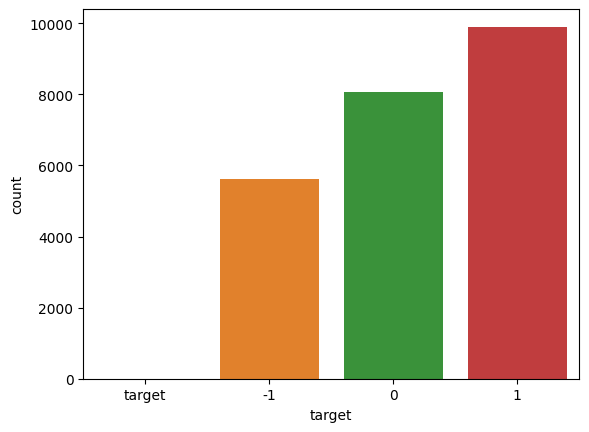

In [101]:
import seaborn as sns
sns.countplot(x='target', data=df)

In [102]:
# Selecting the text and Target column for our further analysis
data=df[['text','target']]

In [103]:
# Replacing the values to ease understanding. (Assigning 1 to Positive sentiment 4)
data['target'] = data['target'].replace(4,1)

<ipython-input-103-3a16057e415e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = data['target'].replace(4,1)


In [104]:
# Printing unique values of target variables
data['target'].unique()

array(['target', '-1', '0', '1'], dtype=object)

In [105]:
# Separating positive and negative tweets
data_pos = data[data['target'] == 1]
data_neg = data[data['target'] == 0]

In [106]:
# aking one-fourth of the data so we can run it on our machine easily
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]

In [107]:
# Combining positive and negative tweets
dataset = pd.concat([data_pos, data_neg])

In [108]:
# Making statement text in lowercase
dataset['text']=dataset['text'].str.lower()
dataset['text'].tail()

Series([], Name: text, dtype: object)

In [109]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [110]:
# Cleaning and removing the above stop words list from the tweet text
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))
dataset['text'].head()

Series([], Name: text, dtype: object)

In [111]:
#  Cleaning and removing punctuations
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))
dataset['text'].tail()

Series([], Name: text, dtype: object)

In [112]:
# Cleaning and removing repeating characters
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_repeating_char(x))
dataset['text'].tail()

Series([], Name: text, dtype: object)

In [113]:
# Cleaning and removing URLs
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))
dataset['text'].tail()

Series([], Name: text, dtype: object)

In [114]:
# Cleaning and removing numeric numbers
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x))
dataset['text'].tail()

Series([], Name: text, dtype: object)

In [115]:
#  Separating input feature and label
X=data.text
y=data.target

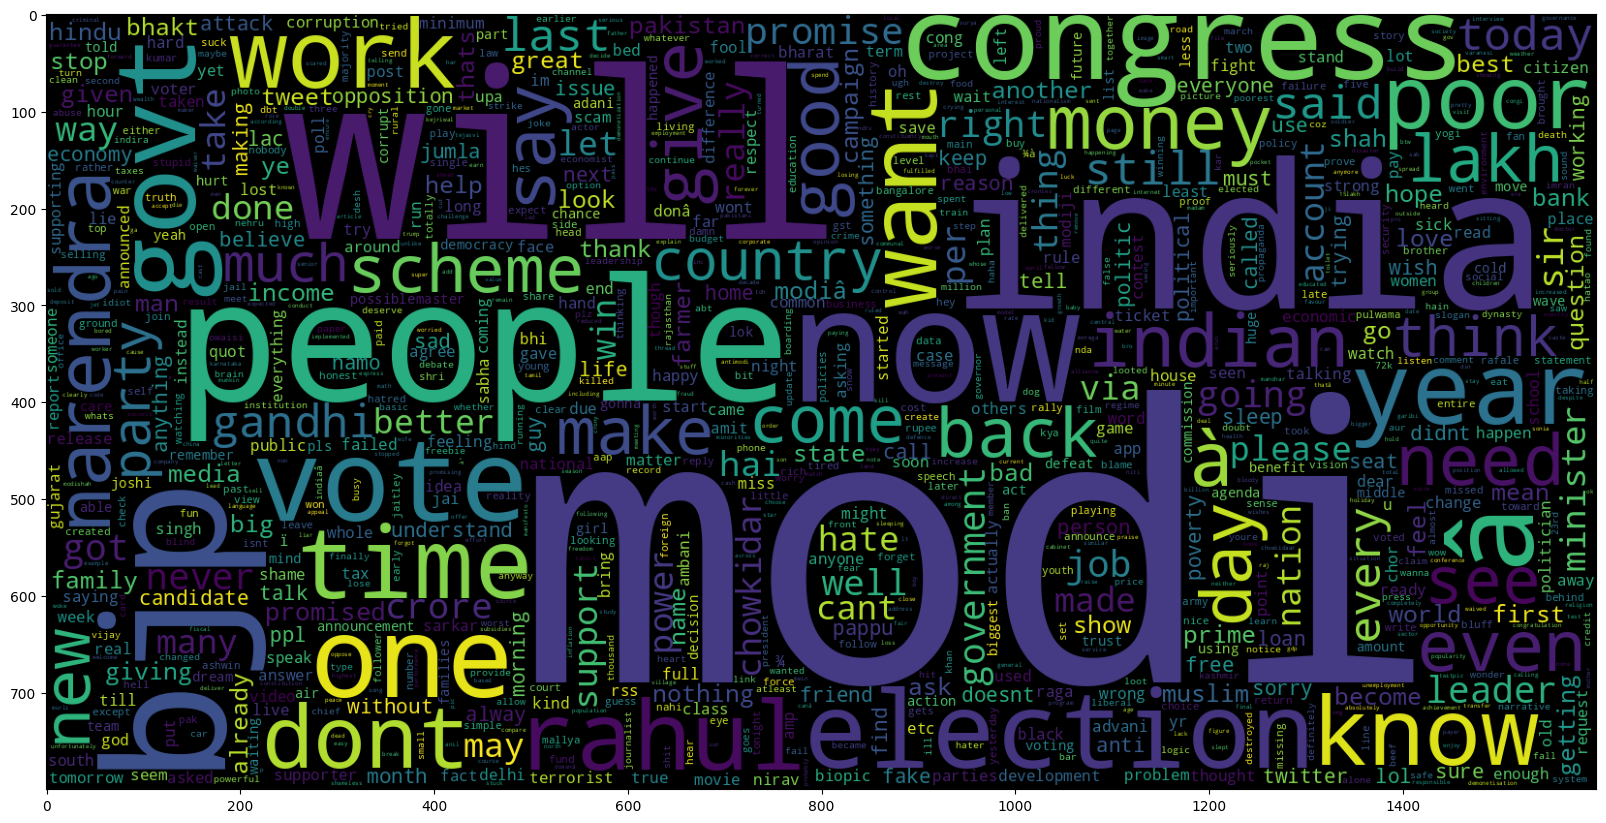

In [116]:
# Plot a cloud of words for negative tweets
data_neg = data['text'][:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

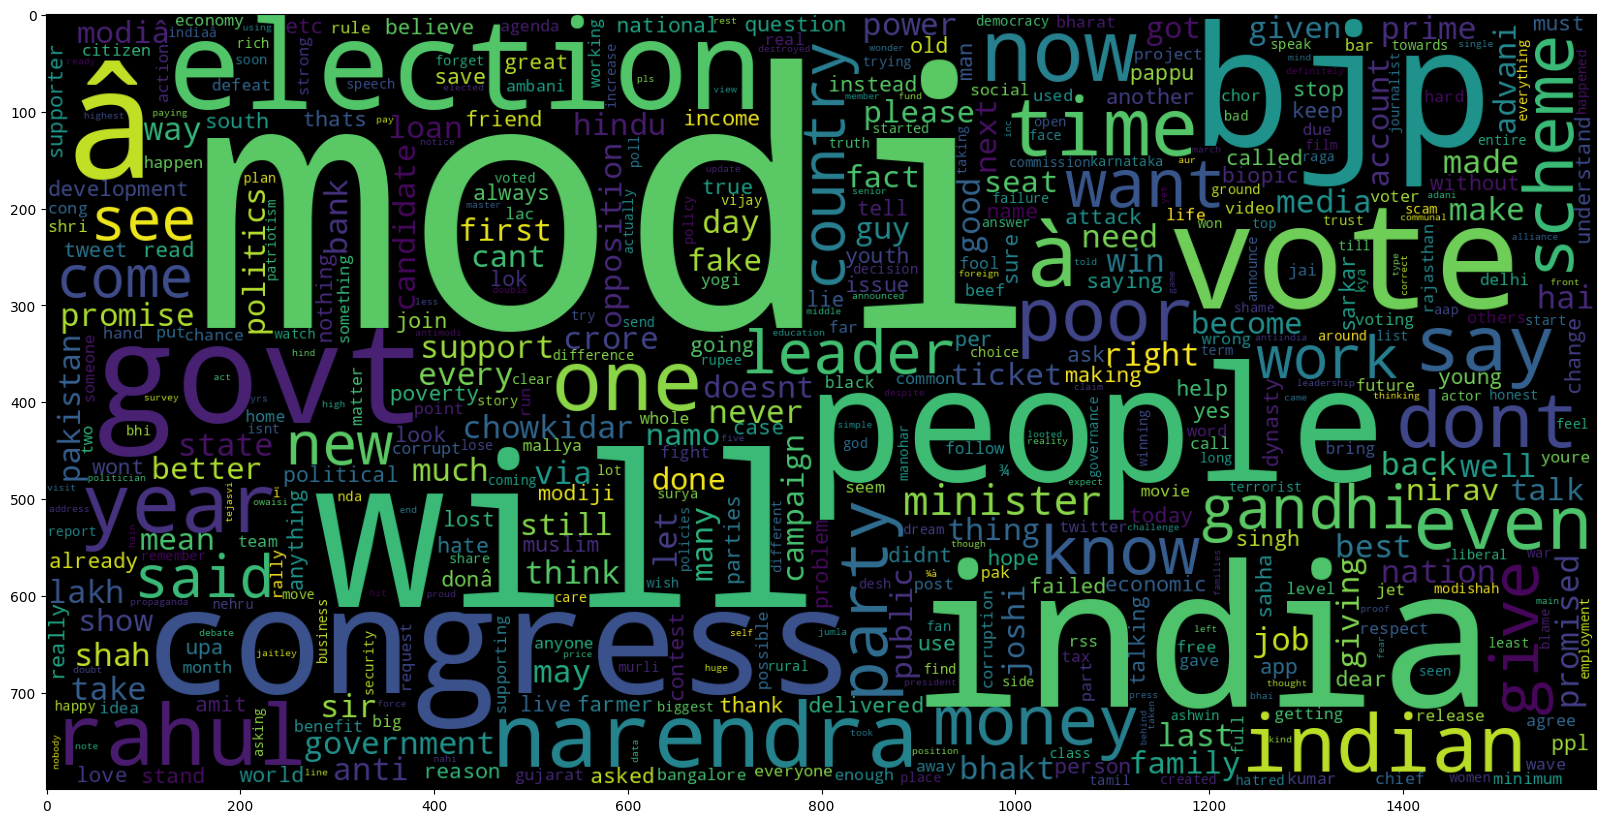

In [117]:
# Plot a cloud of words for positive tweets
data_pos = data['text'][20000:]
wc = WordCloud(max_words = 500 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)